In [80]:
import math
import pandas as pd
import numpy as np
import numpy.ma as ma
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['figure.dpi'] = 120 # set default DPI

def loadData(nbChunks = 0): # <= 0 to load all chunks, positive integer to load specific number of chunks
    min_books = 100
    min_reviewers = 2000
    reviewers = {}
    books = {}
    chunks = pd.read_json(
        '../Dataset/Books.json', lines=True, chunksize=500000,
        typ="frame", orient="records", dtype={"asin": str, "reviewerID": str, "overall": int}
    )
    for chunk in chunks:
        for _, item in chunk.iterrows():
            asin = item["asin"]
            rate = item["overall"]
            reviewerID  = item["reviewerID"]
            if asin not in books:
                books[asin] = {}
            if reviewerID  not in reviewers:
                reviewers[reviewerID] = {}
            books[asin][reviewerID] = rate
            reviewers[reviewerID][asin] = rate
        nbChunks -= 1
        if (nbChunks == 0): break
    # Get books and reviewers keys
    book_keys = np.array(list(books.keys()))
    reviewers_keys = np.array(list(reviewers.keys()))
    # Sort them based on number of reviews/reviewers (we get an index)
    books_rc_sorted_i = np.argsort(np.array([ len(books[b].keys()) for b in book_keys ]))
    reviewers_rc_sorted_i = np.argsort(np.array([ len(reviewers[r].keys()) for r in reviewers_keys ]))
    # Construct a dataset using biggest books and users who have the most reviews
    data = np.array([ 
        [ books[b][r] if r in books[b] else np.nan for b in book_keys[books_rc_sorted_i[-min_books:]] ] 
        for r in  reviewers_keys[reviewers_rc_sorted_i[-min_reviewers:]]
    ])
    # Construct a panda dataframe
    df = pd.DataFrame(
        data=data,
        index=reviewers_keys[reviewers_rc_sorted_i[-min_reviewers:]],
        columns=book_keys[books_rc_sorted_i[-min_books:]]
    )
    # Remove all rows and columns that contain only NaNs
    df = df.iloc[~np.isnan(df.to_numpy()).all(axis=1), ~np.isnan(df.to_numpy()).all(axis=0)]
    return df


fr1 = loadData(1)
display(fr1)

,006199104X,0061726826,0062076108,0060512806,006197806X,0060755334,0060572965,0062302426,0060584750,0060878061,...,0062255657,0062024027,0060098902,0061537934,0002247399,0061950726,0002007770,0007386648,0007442920,0007444117
A3TEPW3KREWO3I,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN
A2C4MKATLLGFB0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN
A1GUWFBWRXTJG0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A3ELOCDHFEPEKJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2F7CCPK4QL359,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A14OJS0VWMOSWO,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A320TMDV6KCFU,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AHUT55E980RDR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
A2F6N60Z96CAJI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,5.0,5.0,5.0,5.0,5.0,NaN,NaN


In [81]:
# Display some the sorted number of reviews/books we have got in our dataset
display(
    pd.DataFrame(
        data=np.sort((~np.isnan(fr1.to_numpy())).sum(axis=0))[::-1],
        columns=["Number of reviews per book"],
    )
)
display(
    pd.DataFrame(
        data=np.sort((~np.isnan(fr1.to_numpy())).sum(axis=1))[::-1],
        columns=["Number of books per reviewer"],
    )
)

,Number of reviews per book
0,192
1,153
2,152
3,144
4,140
...,...
95,16
96,16
97,9
98,8


,Number of books per reviewer
0,34
1,28
2,23
3,22
4,19
...,...
1609,1
1610,1
1611,1
1612,1


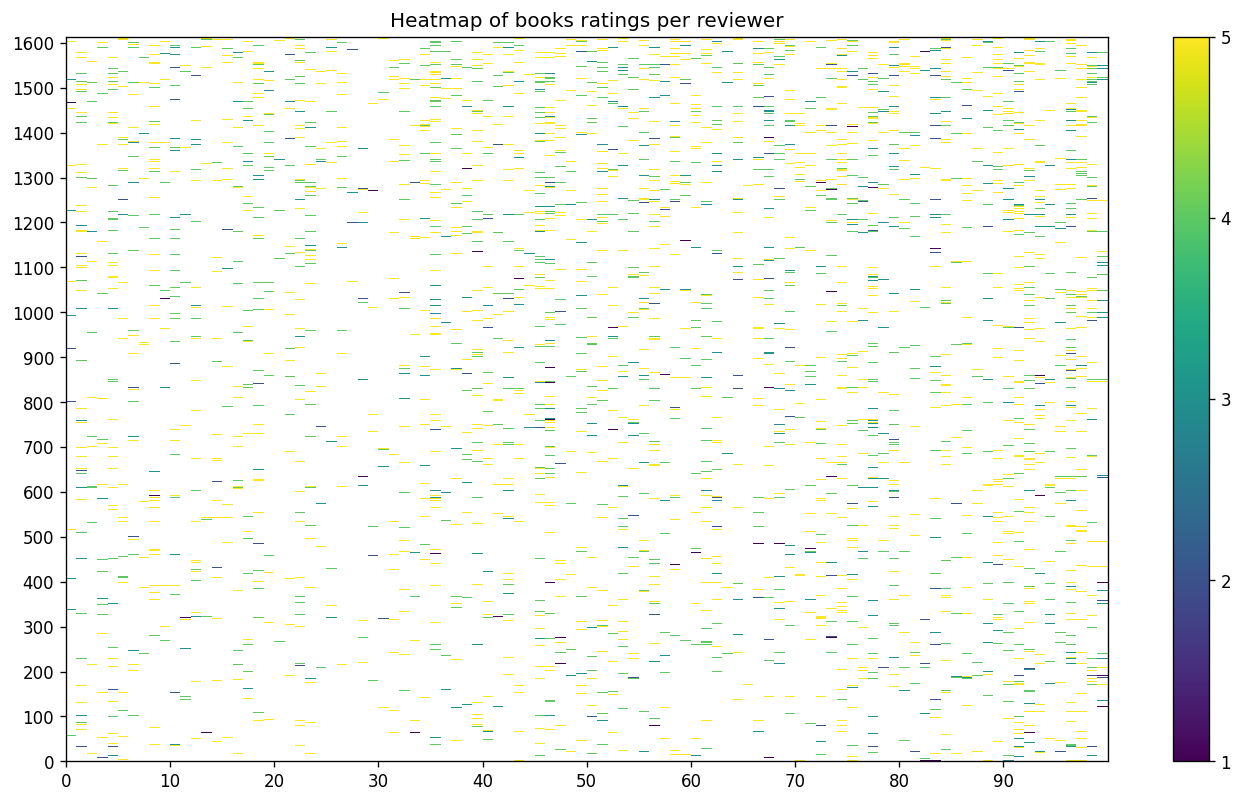

In [82]:
def plot_df(ax, df, title=""):
    pc = ax.pcolormesh(df)
    ax.set_yticks(np.arange(0, len(df.index), 100))
    ax.set_xticks(np.arange(0, len(df.columns), 10))
    cb = fig.colorbar(pc)
    cb.ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_title(title)

# Plot the heat map of our fr1 panda dataframe
fig, ax = plt.subplots(nrows=1, figsize=(14.0, 8.0))
plot_df(ax, fr1, 'Heatmap of books ratings per reviewer')
plt.show()

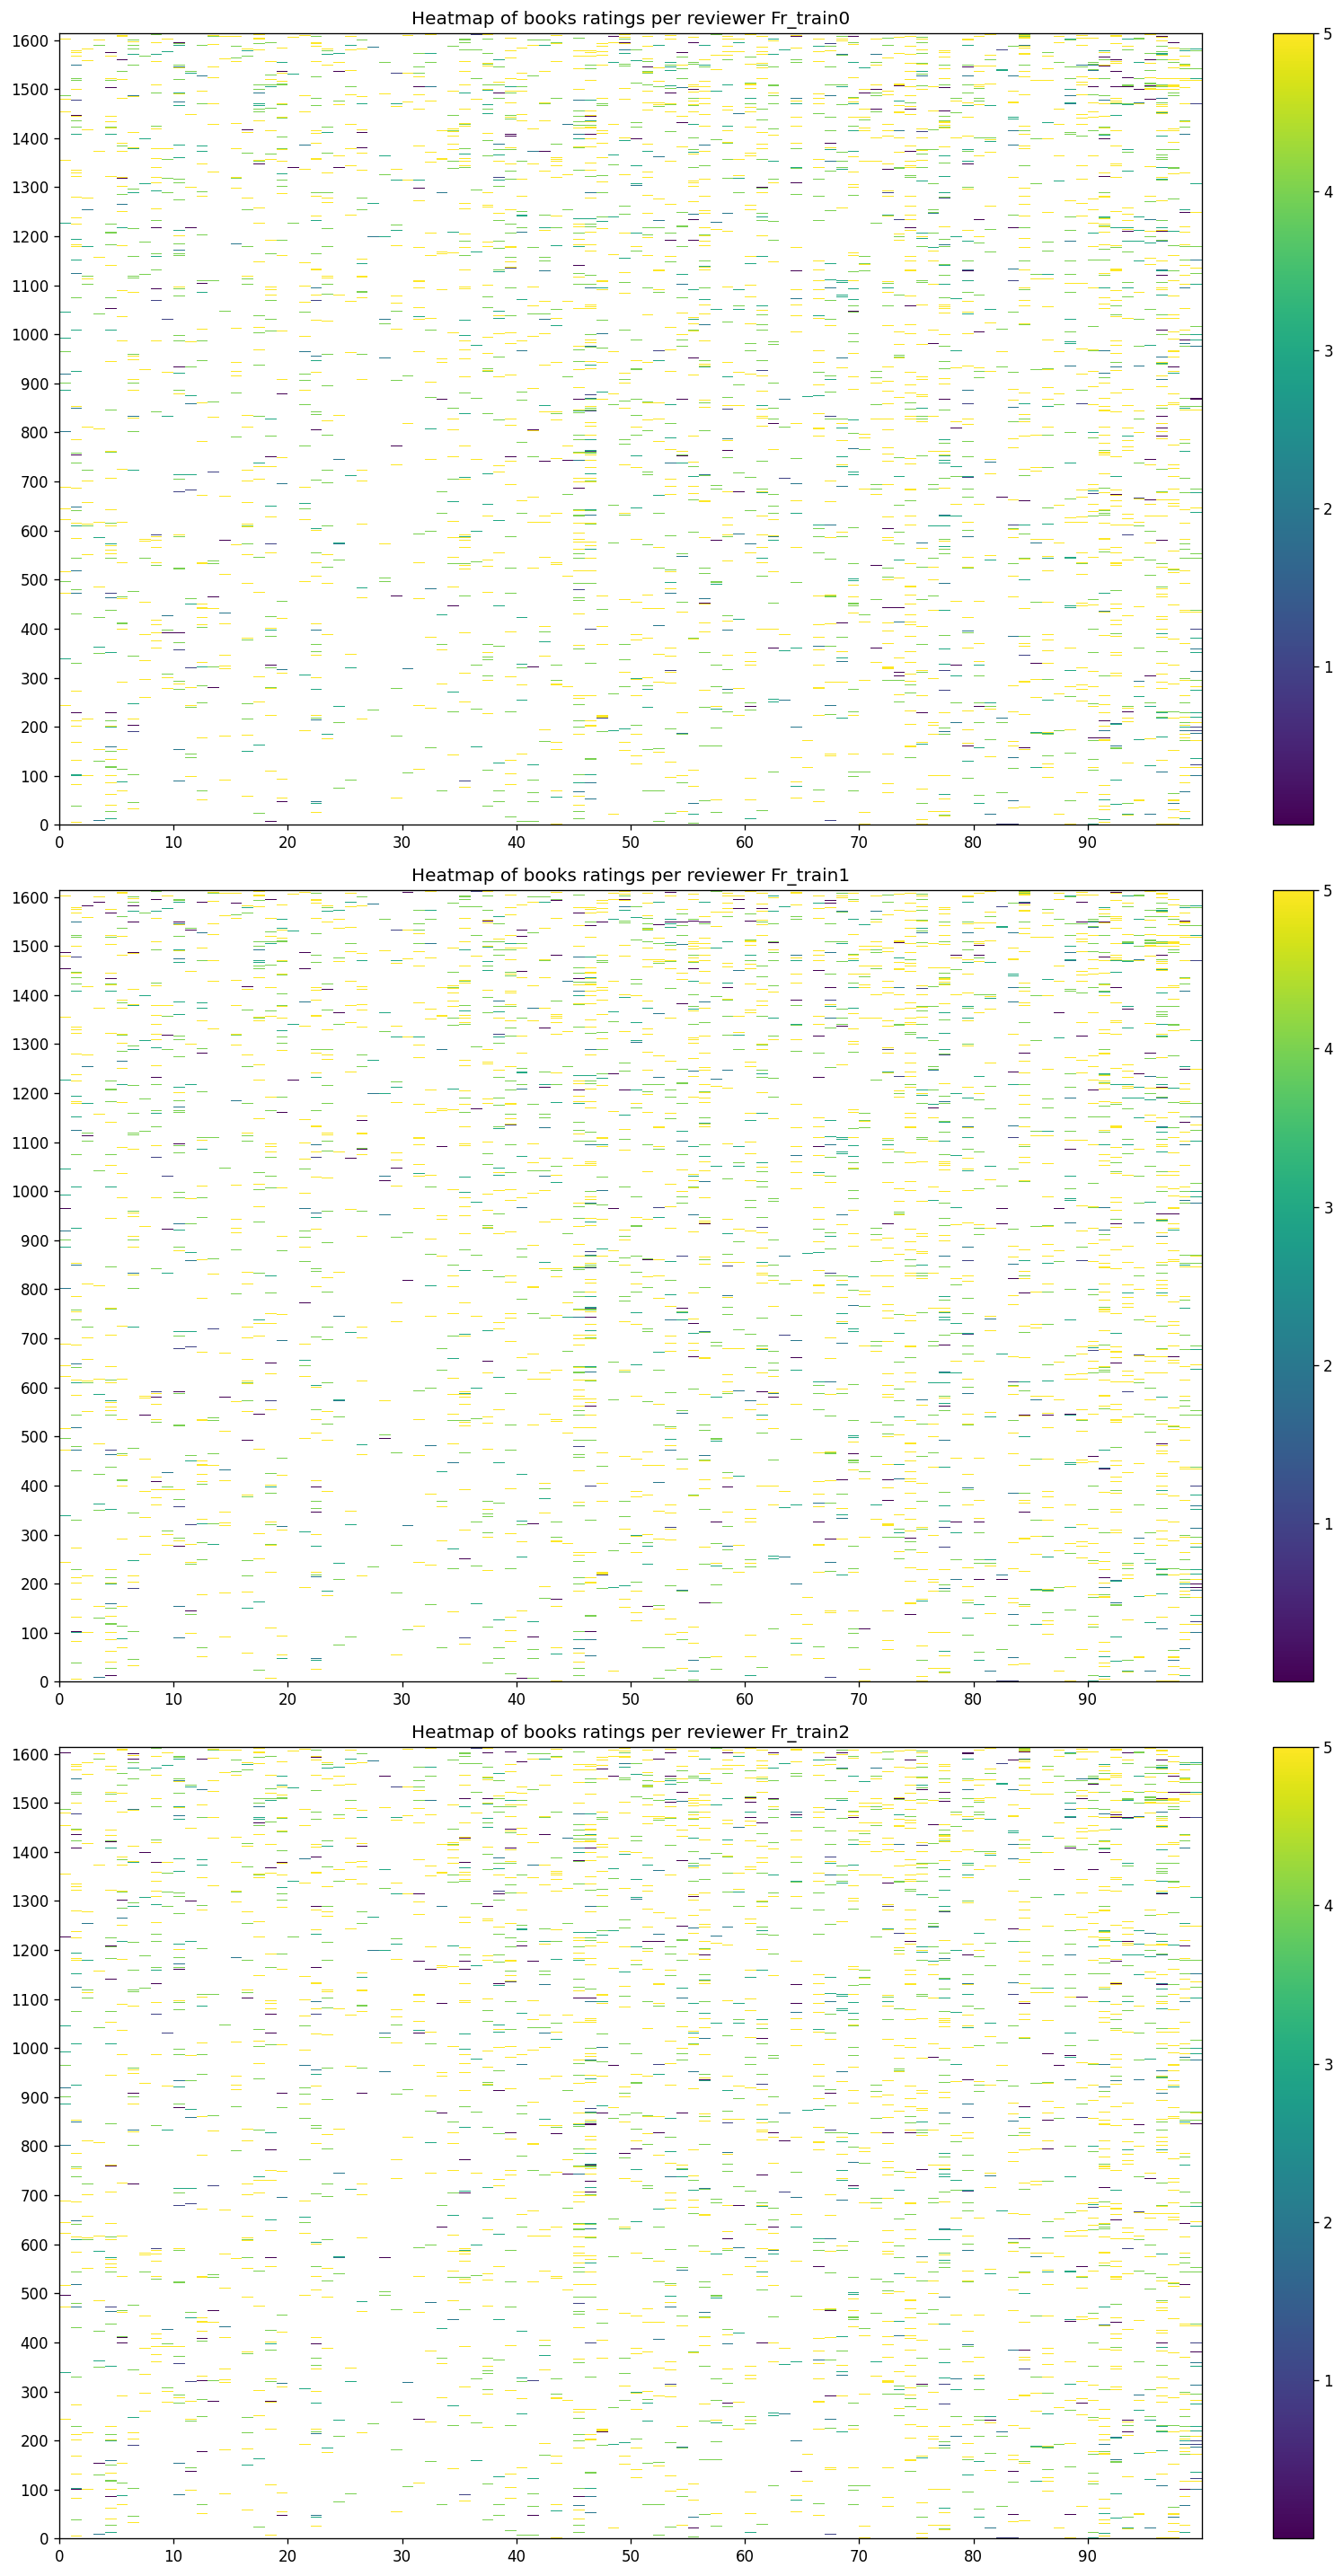

In [83]:
def DataSelection(df, nb_train=3):
    """
    A function that constructs nb_train corrupted data frame out of a given dataset
    """
    def CorruptData(df):
        """
        A function that corrupts the panda dataframe df by choosing randomly 30% of the rows
        and a 30% of non NaN columns and sets them to NaN
        """
        new_df = df.copy() # Do a deep copy (avoid corrupting our original dataset)
        np_arr = new_df.to_numpy() # We have to work on a Numpy array
        # Get random number of indicies in [0, new_df.shape[0]] with size 30% of the number of rows
        rows = np.random.randint(low=0, high=new_df.shape[0], size=np.int64(new_df.shape[0] * 0.3))
        for i in rows: # for each row
            ri = np.argwhere(~np.isnan(np_arr[i,:])).T[0] # Find non-NaN indicies (across each row i)
            cols = np.random.choice(ri, np.int64(len(ri) * 0.3)) # Get 30% random sample of the non-NaN indicies
            new_df.iloc[i, cols] = 0 # Force the ith row and the randomly chosens cols to 0
        return new_df # return our new dataframe
    # Construct a list of data frames
    df_list = [ CorruptData(df) for _ in range(nb_train) ]
    return df_list

# Construct our train list and plot them
train_list = DataSelection(fr1)
fig, axs = plt.subplots(nrows=3, figsize=(14.0, 8.0*3))

# enumerate allows us to get index and values while iterating through our list
for i, df in enumerate(train_list):
    plot_df(axs[i], df, f'Heatmap of books ratings per reviewer Fr_train{i}')

# Do a tight layout to get a tidy picture
fig.tight_layout()
plt.show()

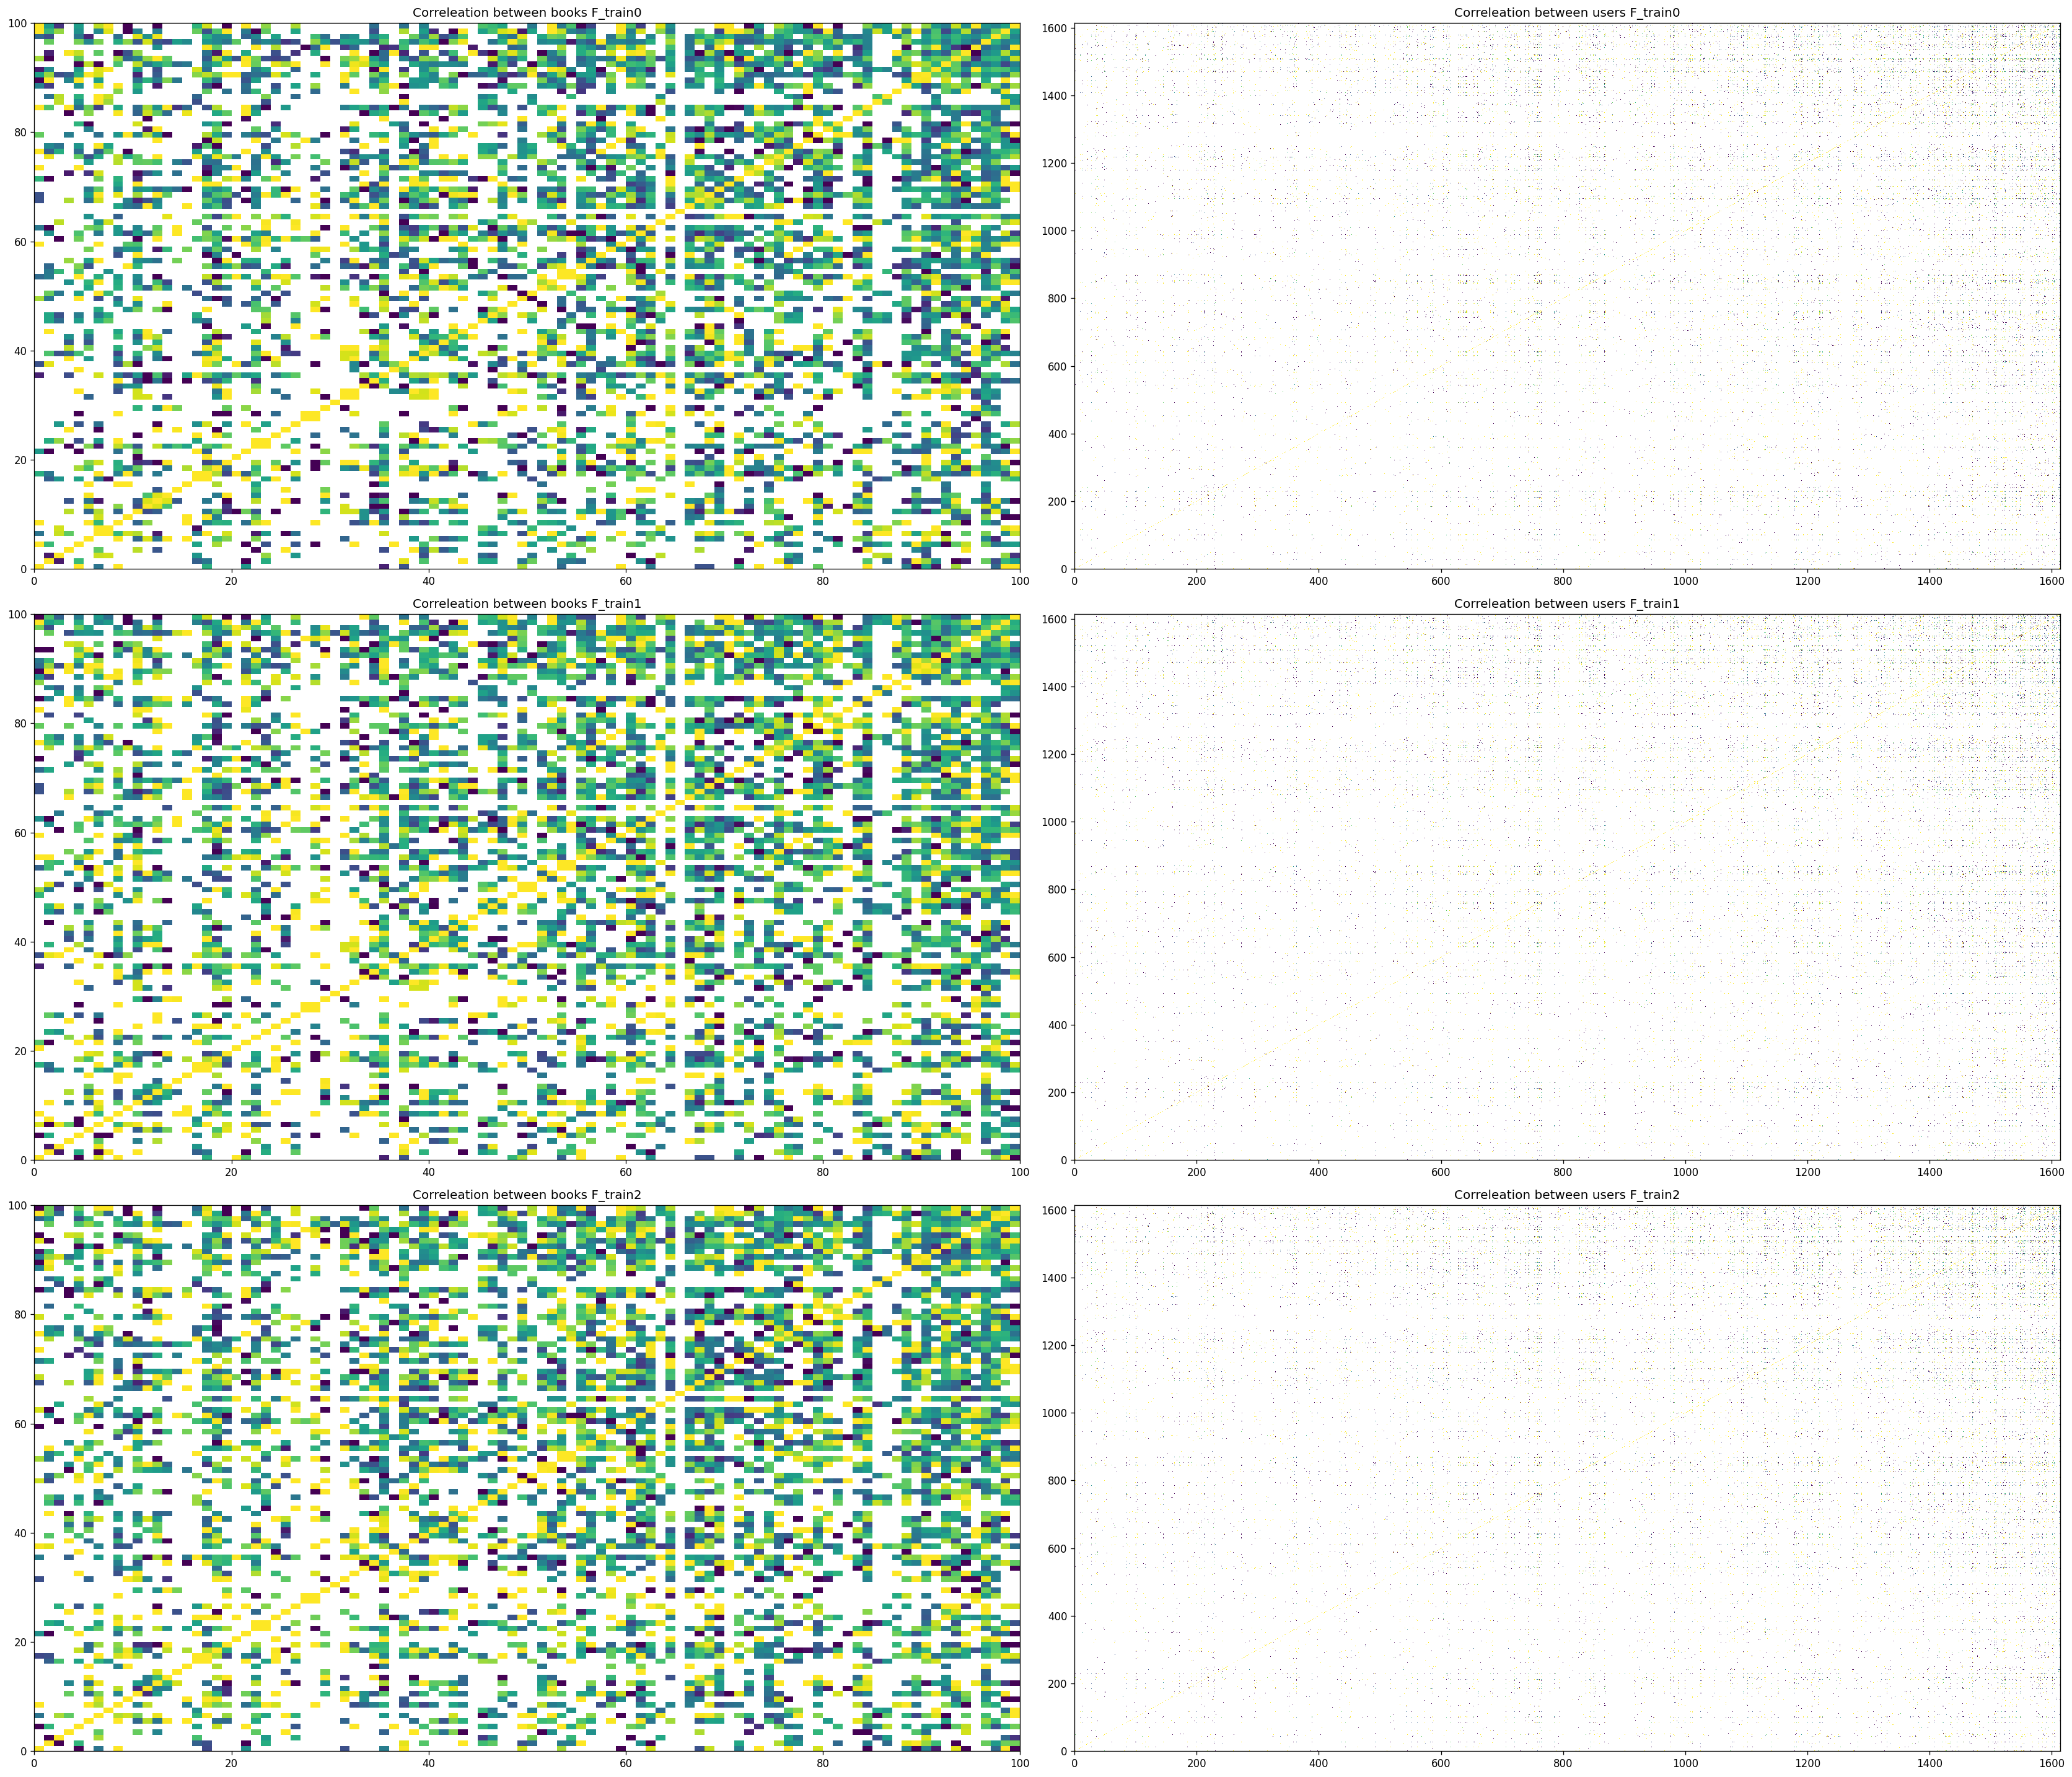

In [84]:
# PCC = Pearson correlation coefficient, u = user, b = books
# PCC of the users for each DataFrame in our train_list
pccs_u = [ None for _ in range(len(train_list)) ]
# PCC of the books for each DataFrame in our train_list
pccs_b = [ None for _ in range(len(train_list)) ]

# Prepare to plot
fig, axs = plt.subplots(len(train_list), 2, figsize=(14.0*2, 8.0*3))

for i, df in enumerate(train_list):
    # By default computes correlation accrros columns
    pccs_b[i] = df.corr(method="pearson") # We have books in columns so this is PCCS of books
    pccs_u[i] = df.T.corr(method="pearson") # Transpose and then we get correlations across users
    pc = axs[i,0].pcolormesh(pccs_b[i]) # Heatmap plot of books
    pc = axs[i,1].pcolormesh(pccs_u[i]) # Heatmap plot of users
    axs[i,0].set_title(f"Correleation between books F_train{i}")
    axs[i,1].set_title(f"Correleation between users F_train{i}")

# Do a tight layout to get a tidy picture
fig.tight_layout()
plt.show()

In [85]:
# For each book_j takes the 3 most similar books
sim_Ik = []  # sim_Ik: k length list of set of top3's most similar book of each book
"""
example: sim_Ik = [
    [
        [a_0, b0, c0],  books of indexes: a_0, b0, c0 are the 3 most similar to book_0
        ...
        [a_j, b_j, c_j],  books of indexes: a_j, b_j, c_j are the 3 most similar to book_j
        ...
        [a_p, b_p, c_p]  books of indexes: a_p, b_p, c_p are the 3 most similar to book_p
    ], for the k-th train_set
    ...
]
"""
for pcc_mat in pccs_b:
    # delete the diag of the matrix
    pcc_mat_copy = pcc_mat.to_numpy()
    pcc_mat_copy[~np.eye(pcc_mat_copy.shape[0],dtype=bool)].reshape(pcc_mat_copy.shape[0],-1)
    # takes top4 similar books of book_i and delete the center value (pcc with itself)
    top3_list_idx = np.argpartition(np.abs(pcc_mat.to_numpy()), -3, axis=1)[:,-3:]
    sim_Ik.append(top3_list_idx)

# for each user_i takes the 8 most similar users
sim_Uk = []  # sim_Uk: k length list of set of top8's most similar user of each user
for pcc_mat in pccs_u:
    # delete the diag of the matrix
    pcc_mat_copy = pcc_mat.to_numpy()
    pcc_mat_copy[~np.eye(pcc_mat_copy.shape[0],dtype=bool)].reshape(pcc_mat_copy.shape[0],-1)
    # takes top 8 similar users of user_i and delete the center value (pcc with itself)
    top8_list_idx = np.argpartition(np.abs(pcc_mat.to_numpy()), -8, axis=1)[:,-8:]
    sim_Uk.append(top8_list_idx)

display(pd.DataFrame(
    data=[ [train_list[0].columns[i] for i in b ] for b in sim_Ik[0] ],
    columns=["Top 1", "Top 2", "Top 3"],
    index=train_list[0].columns
))
display(pd.DataFrame(
    data=[ [train_list[0].index[i] for i in u] for u in sim_Uk[0] ],
    columns=["Top 1", "Top 2", "Top 3", "Top 4", "Top 5", "Top 6", "Top 7", "Top 8"],
    index=train_list[0].index
))

,Top 1,Top 2,Top 3
006199104X,0061726826,0062273248,0061009059
0061726826,0060584750,0007327064,006199104X
0062076108,006222543X,0062316869,0062197258
0060512806,006222543X,0062316869,0007444117
006197806X,0060817089,006085880X,0060987103
...,...,...,...
0061950726,0061728977,0062278789,006199104X
0002007770,0062294776,006230240X,006199104X
0007386648,0061009059,0062059939,0061245089
0007442920,0061939897,0060838582,0061728977


,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8
A3TEPW3KREWO3I,A3JPFWKS83R49V,ATANE2SC44592,A3JPTQPOKO6TVO,A3FVAWZNKW9GX,A38Z8ZXX1BPFRL,A3JAPMZJ8GYRB8,AIWDJ3S85O10Q,AFVQZQ8PW0L
A2C4MKATLLGFB0,A3FVAWZNKW9GX,A3JAPMZJ8GYRB8,A102Z3T7NSM5KC,A2UG66FH9CGITD,A1KZ6HQPP5S5DN,A2LIR7WQ20GXQ7,A3M1PA1C98XNGN,A29IYGR7SNPRIV
A1GUWFBWRXTJG0,ATANE2SC44592,A5HVPX1ETWWIV,A1BZT1ZLNJ24DH,A3JAPMZJ8GYRB8,A102Z3T7NSM5KC,A3JPFWKS83R49V,A38Z8ZXX1BPFRL,AFVQZQ8PW0L
A3ELOCDHFEPEKJ,ATANE2SC44592,A5HVPX1ETWWIV,A1BZT1ZLNJ24DH,A3JAPMZJ8GYRB8,A102Z3T7NSM5KC,A3JPFWKS83R49V,A38Z8ZXX1BPFRL,AFVQZQ8PW0L
A2F7CCPK4QL359,ATANE2SC44592,A5HVPX1ETWWIV,A1BZT1ZLNJ24DH,A3JAPMZJ8GYRB8,A102Z3T7NSM5KC,A3JPFWKS83R49V,A38Z8ZXX1BPFRL,AFVQZQ8PW0L
...,...,...,...,...,...,...,...,...
A14OJS0VWMOSWO,ATANE2SC44592,A5HVPX1ETWWIV,A1BZT1ZLNJ24DH,A3JAPMZJ8GYRB8,A102Z3T7NSM5KC,A3JPFWKS83R49V,A38Z8ZXX1BPFRL,AFVQZQ8PW0L
A320TMDV6KCFU,ATANE2SC44592,A5HVPX1ETWWIV,A1BZT1ZLNJ24DH,A3JAPMZJ8GYRB8,A102Z3T7NSM5KC,A3JPFWKS83R49V,A38Z8ZXX1BPFRL,AFVQZQ8PW0L
AHUT55E980RDR,A38Z8ZXX1BPFRL,A102Z3T7NSM5KC,A5HVPX1ETWWIV,A1KZ6HQPP5S5DN,A3JAPMZJ8GYRB8,AIWDJ3S85O10Q,A3FVAWZNKW9GX,A29IYGR7SNPRIV
A2F6N60Z96CAJI,A1LKHK7CTD9LA1,A2SHQJP6PNQTLD,AOV3ZCETYEHE9,A1D8D2LIPQPGMZ,A1C3Z9RO1BKMYF,A3P3UOHYBFRGJN,A1NOBRCN20NGD5,A29IYGR7SNPRIV


In [86]:
# Compute the sum of Zk matrix
def compute_Z(ts, nb_set, book, user, sim_Ik, sim_Uk):  # need to cache sim_Ik, sim_Uk
    """
    df: working dataframe
    book: target book index
    user: target user index
    sim_Ik: k length list of set of top3's most similar book of each book
    sim_Uk: k length list of set of top8's most similar user of each user
    """
    Z = np.zeros((8, 5))
    for book in sim_Ik[nb_set][book]:
        Zk = []
        for reviewer in sim_Uk[nb_set][user]:
            Zk.append(
                [
                    (ts.iloc[reviewer][book] if ts.iloc[reviewer][book] and ts.iloc[reviewer][book] == r else 0) for r in range(1, 6)
                ]
            )
        Z += np.array(Zk)
    return np.transpose(Z)


def rating(ts, nb_set, book, reviewer, W, Z=None):
    if Z is None: Z = compute_Z(ts, nb_set, book, reviewer, sim_Ik, sim_Uk)
    return np.linalg.norm(np.dot(W, Z))


def gradW_Eval(ts, nb_set, W):  # compute the grad of Eval metric function
    n, p = ts.shape
    grad = []
    for k in range(W.shape[0]):
        dev = np.zeros((1, W.shape[0]))
        for i in range(n):
            for j in range(p):
                Z = compute_Z(ts, nb_set, j, i, sim_Ik, sim_Uk)
                dev += W[k] * np.sum(np.dot(Z[:,k], np.dot(W, Z[:,k]))) / rating(ts, nb_set, j, i, W, Z)
        dev /= n*p
    grad.append(dev)
    return np.array(grad)


def update_W(ts, nb_set, W, t):
    return W - t*gradW_Eval(ts, nb_set, W)


def train(train_list, t=0.01, eps=0.1, max_itr=10):  # gradient descent W training
    """
    t: learning rate (need to be set by testing various values)
    eps: stop condition (need to be set by testing various values)
    """
    import random
    Wk = []
    for i, train_set in enumerate(train_list):
        W_prev = np.array([ random.random() for _ in range(5) ])
        W = update_W(train_set, i, W_prev, t)
        itr = 0
        while np.linalg.norm(W - W_prev) <= eps or itr < max_itr:
            W_prev = W
            W = update_W(train_set, i, W_prev, t)
            itr += 1
        Wk.append(W)
    return Wk  # our list of W parameters of k train sets


def predict(train_list, Wk):  # predict the rating for hidden cells of each train_set matrix
    predictions_list = []  # list of dict: mapping pairs of user_i, book_j to rating_ij
    k = 0
    for train_set, W in zip(train_list, Wk):  # need to set hidden rating as 0 or -1 (if use nan, we can't know witch value is hidden)
        n, p = train_set.shape
        predictions = {}
        for i in range(n):
            for j in range(p):
                if train_set.iloc[i][j] <= 0:
                    predictions[(i, j)] = rating(train_set, k, j, i, W)
        k += 1
        predictions_list.append(predictions)
    return predictions_list


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


def errorEvaluation(df, predictions_list):
    # arrange data to user error evaluation metrics
    y_pred_list, y_true_list = [], []
    for predictions in predictions_list:
        y_pred, y_true = [], []
        for (i, j), r in predictions.items():
            y_pred.append(r)  # predicted rating
            y_true.append(df.iloc[i][j])  # original rating
        y_pred_list.append(y_pred)
        y_true_list.append(y_true)
        
    # compute errors
    rmse = [mean_squared_error(y_pred, y_true) for y_pred, y_true in zip(y_pred_list, y_true_list)]
    mae = [mean_absolute_error(y_pred, y_true) for y_pred, y_true in zip(y_pred_list, y_true_list)]
    dataframe = pd.DataFrame(data={"RMSE": rmse, "MAE": mae}, index=["Test1", "Test2", "Test3"])
    display(dataframe)  # first display
    
    # Compute means errors including all tests and strandard deviation
    # compute std  TODO: change the compute of std, we need to compute error std between y_pred and y_true ?
    y_pred_std_list = [np.std(y_pred) for y_pred in y_pred_list]
    y_true_std_list = [np.std(y_true) for y_pred in y_true_list]
    dataframe.insert(2, "y_pred_std", y_pred_std_list)
    dataframe.insert(3, "y_true_std", y_true_std_list)
    metrics_means = {
        [
            [np.mean(rmse), np.mean(mae), np.mean(y_pred_std_list), np.mean(y_true_std_list)],
            [np.std(rmse), np.std(mae), np.std(y_pred_std_list), np.mean(y_true_std_list)]
        ]
    }
    total_df = pd.DataFrame(
        data=metrics_means,
        index=["Final Means", "Final STD"],
        columns=["RMSE", "MAE", "y_pred_std", "y_true_std"]
    )
    final_dataframe = pd.concat([dataframe, total_df])
    display(final_dataframe)  # second display (with means and std)
    
    # bar plot
    fig, axs = plt.subplots(2, 2, figsize=(14.0*2, 8.0*3))
    axs[0,0].bar([1,2,3], rmse)
    axs[0,0].set_title("RMSE barplot view: mean="+np.mean(rmse))
    axs[0,1].bar([1,2,3], mae)
    axs[0,1].set_title("MAE barplot view: mean="+np.mean(mae))
    axs[1,0].bar([1,2,3], rmse)
    axs[1,0].set_title("pred_std barplot view: mean="+np.mean(y_pred_std_list))
    axs[1,1].bar([1,2,3], mae)
    axs[1,1].set_title("true_std barplot view: mean="+np.mean(y_true_std_list))
    return final_dataframe

Wk_train = train(train_list)
predictions_list = predict(train_list, Wk_train)
errors_df = errorEvaluation(df, predictions_list)
display(errors_df)

C:\Users\amine\AppData\Local\Temp\ipykernel_1392\3739255691.py:36: RuntimeWarning: invalid value encountered in double_scalars
  dev += W[k] * np.sum(np.dot(Z[:,k], np.dot(W, Z[:,k]))) / rating(ts, nb_set, j, i, W, Z)


KeyboardInterrupt: 